In [2]:
import nltk as nltk
import nltk.corpus  
from nltk.text import Text
from nltk.corpus import stopwords
import pandas as pd
import re
import sys
import matplotlib.pyplot as plt
import numpy as np
import scikitplot as skplt
import glob
import os
import spacy
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, HashingVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, roc_auc_score
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn import metrics


### Read in data

First section is only for the scored test set with generated summaries

In [9]:
# get max csv
# list_of_files = glob.glob('Z:/final_data/scored_data/scored_rouged_df*.csv') # * means all if need specific format then *.csv
# ckpt_text = max(list_of_files, key=os.path.getctime)
# print(ckpt_text)

# read in actual notes
# notes = pd.read_csv(ckpt_text,index_col=0,keep_default_na=False)

Z:/final_data/scored_data\scored_rouged_df.csv


C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2728: DtypeWarning: Columns (2,70,326) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [10]:
# notes.head()

,patient_id,age_at_last_encounter,gender,race,ethnicity,date_of_death,encounter_id,enc_eio,visit_status_1,visit_status_2,...,scored_summaries,rouge-1-f,rouge-1-p,rouge-1-r,rouge-2-f,rouge-2-p,rouge-2-r,rouge-l-f,rouge-2-p.1,rouge-2-r.1
0,49,79,M,White,Not Hispanic or Latino,,10440586,O,Completed,,...,,,,,,,,,,
1,49,79,M,White,Not Hispanic or Latino,,10440586,O,Completed,,...,,,,,,,,,,
2,49,79,M,White,Not Hispanic or Latino,,10440586,O,Completed,,...,,,,,,,,,,
3,49,79,M,White,Not Hispanic or Latino,,10440586,O,Completed,,...,,,,,,,,,,
4,49,79,M,White,Not Hispanic or Latino,,11420608,O,No Show,Completed,...,,,,,,,,,,


In [55]:
# train dat
train_dta = pd.read_csv("Z:/final_data/cohorts_merged_training.csv",keep_default_na=False)

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2728: DtypeWarning: Columns (1,69,325) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
train_dta.head()

,patient_id,age_at_last_encounter,gender,race,ethnicity,date_of_death,encounter_id,enc_eio,visit_status_1,visit_status_2,...,technique,comparison,findings,impressions,elecsig,patient_raw,rawtext,encounter_id_diagnosed,date_diagnosed,ild_status
0,2068804,60,F,White,Not Hispanic or Latino,,7629913,I,Completed,,...,XR PORT CHEST 1V,None,Small lung volumes with bilateral airspace and...,Findings consistent with CHF/fluid overload.,**DATE<[**2017-09-06**]> 9:53 AM **NAME<EEE F...,7629913_446136,"XR PORT CHEST 1V, **DATE<[**2017-09-06**]> 9:1...",,,0
1,2068842,54,M,Black/African-American,Not Hispanic or Latino,,6781649,O,Completed,,...,,,,,,,,,,0
2,2068842,54,M,Black/African-American,Not Hispanic or Latino,,6781649,O,Completed,,...,Noncontrast thin section axial CT images of th...,None.,There is evidence of prior endoscopic surgery ...,1. Mild paranasal sinus disease including muco...,**DATE<[**2017-09-06**]> 1:36 PM **NAME<ZZZ AA...,6781649_1155203,"CT [**Company 1**] FUSION WO CONTRAST, **DATE<...",,,0
3,2068842,54,M,Black/African-American,Not Hispanic or Latino,,7649307,O,Completed,,...,,,,,,,,,,0
4,2068866,36,F,White,Hispanic or Latino,,7589589,O,Completed,,...,XR CHEST PA/LATERAL,None.,Right upper lobe resection via thoracotomy wit...,No significant abnormality.,**DATE<[**2017-08-21**]> 3:53 PM **NAME<EEE FF...,7589589_108353,"XR CHEST PA/LATERAL, **DATE<[**2017-08-21**]> ...",,,0


In [56]:
#Coalesce adm_date_d and start_date_d where no adm_date_d
train_dta['init_date'] = np.where(train_dta['adm_date_d']=='', train_dta['start_date_d'], train_dta['adm_date_d'])

In [59]:
# Set diagnosis at time of visit
train_dta['ild_diag_prior_to_visit'] = np.where((train_dta['init_date'] < train_dta['date_diagnosed']) | (
train_dta['date_diagnosed'] == ''), 0, 1)

### Let's get only the rows with an impression to build off of. 

We'll need to grab the rows where the ild_diag_prior_to_visit is 0, and has a "finding"

In [48]:
train_dta.head().loc[train_dta.findings.notnull()]

,patient_id,age_at_last_encounter,gender,race,ethnicity,date_of_death,encounter_id,enc_eio,visit_status_1,visit_status_2,...,findings,impressions,elecsig,patient_raw,rawtext,encounter_id_diagnosed,date_diagnosed,ild_status,init_date,ild_diag_prior_to_visit
0,2068804,60,F,White,Not Hispanic or Latino,,7629913,I,Completed,,...,Small lung volumes with bilateral airspace and...,Findings consistent with CHF/fluid overload.,**DATE<[**2017-09-06**]> 9:53 AM **NAME<EEE F...,7629913_446136,"XR PORT CHEST 1V, **DATE<[**2017-09-06**]> 9:1...",,2001-01-01,0,2015-08-23,1
1,2068842,54,M,Black/African-American,Not Hispanic or Latino,,6781649,O,Completed,,...,,,,,,,2001-01-01,0,2015-09-30,1
2,2068842,54,M,Black/African-American,Not Hispanic or Latino,,6781649,O,Completed,,...,There is evidence of prior endoscopic surgery ...,1. Mild paranasal sinus disease including muco...,**DATE<[**2017-09-06**]> 1:36 PM **NAME<ZZZ AA...,6781649_1155203,"CT [**Company 1**] FUSION WO CONTRAST, **DATE<...",,2001-01-01,0,2015-09-30,1
3,2068842,54,M,Black/African-American,Not Hispanic or Latino,,7649307,O,Completed,,...,,,,,,,2001-01-01,0,2015-09-18,1
4,2068866,36,F,White,Hispanic or Latino,,7589589,O,Completed,,...,Right upper lobe resection via thoracotomy wit...,No significant abnormality.,**DATE<[**2017-08-21**]> 3:53 PM **NAME<EEE FF...,7589589_108353,"XR CHEST PA/LATERAL, **DATE<[**2017-08-21**]> ...",,2001-01-01,0,2015-03-31,1


In [60]:
train_dta_ild = train_dta[(train_dta.ild_diag_prior_to_visit==0) & (train_dta.findings.str.len()>0)]
train_dta_ild.shape

(357178, 343)

this is different from source...

In [61]:
train_dta[(train_dta.ild_diag_prior_to_visit==0)].shape

(887297, 343)

### Spacy cleaning

Note english language is not installed. Somebody with sudo needs to run:

python -m spacy download en

@chantel Please submit a ticket

In [62]:
nlp = spacy.load("en", disable=['parser', 'tagger', 'ner'])
stops = stopwords.words("english")

def normalize(comment, lowercase, remove_stopwords):
    if lowercase:
        comment = comment.lower()
    comment = nlp(comment)
    lemmatized = list()
    for word in comment:
        lemma = word.lemma_.strip()
        if lemma:
            if not remove_stopwords or (remove_stopwords and lemma not in stops):
                lemmatized.append(lemma)
    return " ".join(lemmatized)

train_dta_ild['findings_cleaned'] = train_dta_ild['findings'].apply(normalize,lowercase=True,remove_stopwords=True)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [63]:
train_dta_ild.to_csv('train_dta_ild.csv')

In [65]:
import os
os.getcwd()

'Z:\\capstone\\src\\models_ild_diag'

In [64]:
train_dta_ild.head()

,patient_id,age_at_last_encounter,gender,race,ethnicity,date_of_death,encounter_id,enc_eio,visit_status_1,visit_status_2,...,impressions,elecsig,patient_raw,rawtext,encounter_id_diagnosed,date_diagnosed,ild_status,init_date,ild_diag_prior_to_visit,findings_cleaned
0,2068804,60,F,White,Not Hispanic or Latino,,7629913,I,Completed,,...,Findings consistent with CHF/fluid overload.,**DATE<[**2017-09-06**]> 9:53 AM **NAME<EEE F...,7629913_446136,"XR PORT CHEST 1V, **DATE<[**2017-09-06**]> 9:1...",,,0,2015-08-23,0,small lung volume bilateral airspace interstit...
2,2068842,54,M,Black/African-American,Not Hispanic or Latino,,6781649,O,Completed,,...,1. Mild paranasal sinus disease including muco...,**DATE<[**2017-09-06**]> 1:36 PM **NAME<ZZZ AA...,6781649_1155203,"CT [**Company 1**] FUSION WO CONTRAST, **DATE<...",,,0,2015-09-30,0,evidence prior endoscopic surgery include leav...
4,2068866,36,F,White,Hispanic or Latino,,7589589,O,Completed,,...,No significant abnormality.,**DATE<[**2017-08-21**]> 3:53 PM **NAME<EEE FF...,7589589_108353,"XR CHEST PA/LATERAL, **DATE<[**2017-08-21**]> ...",,,0,2015-03-31,0,right upper lobe resection via thoracotomy cli...
6,2068882,28,M,Black/African-American,Not Hispanic or Latino,,6168287,E,Completed,Canceled,...,No significant abnormality.,**DATE<[**2017-09-05**]> 10:19 AM **NAME<GGG H...,6168287_509640,"XR CHEST PA/LATERAL, **DATE<[**2017-09-05**]> ...",,,0,2015-03-27,0,significant pleural parenchymal abnormality . ...
8,2068889,57,F,Black/African-American,Not Hispanic or Latino,,6336463,E,Completed,,...,No evidence of intracranial hemorrhage.,**DATE<[**2017-08-21**]> 8:16 AM **NAME<SSS TT...,6336463_568512,"CT HEAD WO, **DATE<[**2017-08-20**]> 10:25 PM ...",,,0,2015-04-07,0,intracranial hemorrhage identify . intracrania...


### TODO consider repeating with findings_cleaned

In [66]:
X = np.array(train_dta_ild.findings)
Y = np.array(train_dta_ild.ild_status)
print(X.shape)
print(Y.shape)


(357178,)
(357178,)


In [67]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y,random_state=1)
print(X_train.shape)
print(X_test.shape)


(267883,)
(89295,)


In [68]:
vect = CountVectorizer()
vect.fit(X_train)
X_train_dtm = vect.transform(X_train)


In [69]:
# test
X_test_dtm = vect.transform(np.array(X_test))
X_test_dtm


<89295x21894 sparse matrix of type '<class 'numpy.int64'>'
	with 5097518 stored elements in Compressed Sparse Row format>

## Model building

#### Naive bayes

In [69]:
nb = MultinomialNB()
# train and time the model using X_train_dtm
%time nb.fit(X_train_dtm, Y_train)

Wall time: 391 ms


MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [70]:
# class preds
Y_pred_class_nb = nb.predict(X_test_dtm)

# calculate accuracy of class predictions
print(metrics.accuracy_score(Y_test, Y_pred_class_nb))

0.5625837864504574


             precision    recall  f1-score   support

          0       0.97      0.55      0.70     86779
          1       0.11      0.74      0.19      6464

avg / total       0.91      0.56      0.66     93243

[[47643 39136]
 [ 1650  4814]]


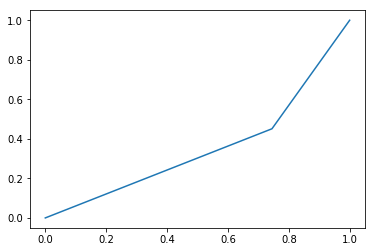

AUC: 0.35312229311250304


In [71]:
# calculate precision and recall
print(classification_report(Y_test, Y_pred_class_nb))

# calculate the confusion matrix
print(metrics.confusion_matrix(Y_test, Y_pred_class_nb))

fpr, tpr, thresholds = metrics.roc_curve(Y_test, Y_pred_class_nb, pos_label=0)

# Print ROC curve
plt.plot(fpr,tpr)
plt.show() 

# Print AUC
auc = np.trapz(tpr,fpr)
print('AUC:', auc)

### Logit

In [72]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
logit = LogisticRegression()
logit.fit(X_train_dtm, Y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [74]:
### training took about 20 min

y_pred = logit.predict(X_test_dtm)
print('Logit predictive accuracy: {:.2f}'.format(logit.score(X_test_dtm, Y_test)))

Logit predictive accuracy: 0.97


In [82]:
# calculate accuracy of class predictions
print(metrics.accuracy_score(Y_test, y_pred))

0.9698639341508483


In [90]:
# calculate precision and recall
print(classification_report(Y_test, y_pred))

# calculate the confusion matrix
logit_conf_mat = metrics.confusion_matrix(Y_test, y_pred)
print(logit_conf_mat)


             precision    recall  f1-score   support

          0       0.97      1.00      0.98     86667
          1       0.36      0.03      0.06      2628

avg / total       0.95      0.97      0.96     89295

[[86519   148]
 [ 2543    85]]


In [91]:
# TODO

chantel # TODO
model score is high also perhaps due to class imbalance, will consider sampling methods to simulate more balanced classes

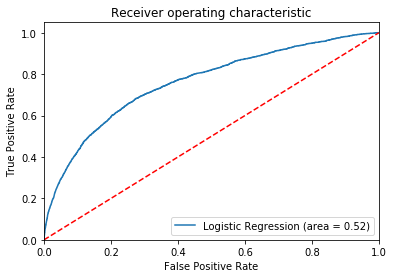

In [95]:
logit_roc_auc = metrics.roc_auc_score(Y_test, y_pred)
fpr_logit, tpr_logit, thresholds_logit = metrics.roc_curve(Y_test, logit.predict_proba(X_test_dtm)[:,1])
plt.figure()
plt.plot(fpr_logit, tpr_logit, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

### Tree Tree Tree

In [88]:
from sklearn import tree
dt = tree.DecisionTreeClassifier()
dt = dt.fit(X_train_dtm, Y_train)

In [89]:
### training took < 20 min

y_pred_dt = dt.predict(X_test_dtm)
print('Decision tree predictive accuracy: {:.2f}'.format(dt.score(X_test_dtm, Y_test)))

Decision tree predictive accuracy: 0.95


In [92]:
# calculate precision and recall
print(classification_report(Y_test, y_pred_dt))

# calculate the confusion matrix
dt_conf_mat = metrics.confusion_matrix(Y_test, y_pred_dt)
print(dt_conf_mat)


             precision    recall  f1-score   support

          0       0.97      0.98      0.98     86667
          1       0.17      0.16      0.16      2628

avg / total       0.95      0.95      0.95     89295

[[84728  1939]
 [ 2220   408]]


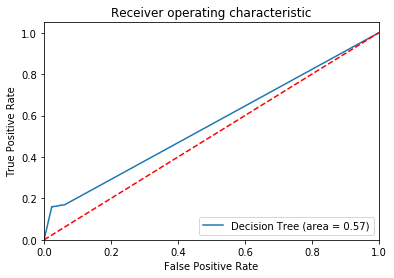

In [94]:
dt_roc_auc = metrics.roc_auc_score(Y_test, y_pred_dt)
fpr_dt, tpr_dt, thresholds_dt = metrics.roc_curve(Y_test, dt.predict_proba(X_test_dtm)[:,1])
plt.figure()
plt.plot(fpr_dt, tpr_dt, label='Decision Tree (area = %0.2f)' % dt_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('DT_ROC')
plt.show()

## Class Sizes

In [97]:
len(train_dta_ild[(train_dta_ild['ild_status']==1)])/len(train_dta_ild)

0.028044840387705848

In [99]:
len(train_dta_ild[(train_dta_ild['ild_status']==0)])

347161

In [102]:
from sklearn import utils
# Separate majority and minority classes
df_majority = train_dta_ild[train_dta_ild['ild_status']==0]
df_minority = train_dta_ild[train_dta_ild['ild_status']==1]
 
# Upsample minority class
df_minority_upsampled = utils.resample(df_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=347161,    # to match majority class
                                 random_state=123) # reproducible results
 
# Combine majority class with upsampled minority class
df_upsampled = pd.concat([df_majority, df_minority_upsampled])
 
# Display new class counts
df_upsampled['ild_status'].value_counts()

1    347161
0    347161
Name: ild_status, dtype: int64

### Redoing train/test setup with upsampled data

In [103]:
X_us = np.array(df_upsampled.findings)
Y_us = np.array(df_upsampled.ild_status)

In [104]:
X_train_us, X_test_us, Y_train_us, Y_test_us = train_test_split(X_us,Y_us,random_state=1)
print(X_train_us.shape)
print(Y_train_us.shape)


(520741,)
(520741,)


In [105]:
vect_us = CountVectorizer()
vect_us.fit(X_train_us)
X_train_dtm_us = vect.transform(X_train_us)


In [106]:
# test
X_test_dtm_us = vect.transform(np.array(X_test_us))
X_test_dtm_us


<173581x21894 sparse matrix of type '<class 'numpy.int64'>'
	with 9460934 stored elements in Compressed Sparse Row format>

### Logit with Upsampled Data

In [107]:
logit_us = LogisticRegression()
%time logit_us.fit(X_train_dtm_us, Y_train_us)

Wall time: 57min 12s


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [108]:
y_pred_logit_us = logit_us.predict(X_test_dtm_us)
print('Logit Upsampled predictive accuracy: {:.2f}'.format(logit_us.score(X_test_dtm_us, Y_test_us)))

Logit Upsampled predictive accuracy: 0.79


In [109]:
# calculate precision and recall
print(classification_report(Y_test_us, y_pred_logit_us))

# calculate the confusion matrix
logit_us_conf_mat = metrics.confusion_matrix(Y_test_us, y_pred_logit_us)
print(logit_us_conf_mat)

             precision    recall  f1-score   support

          0       0.80      0.77      0.79     86439
          1       0.78      0.81      0.80     87142

avg / total       0.79      0.79      0.79    173581

[[66941 19498]
 [16636 70506]]


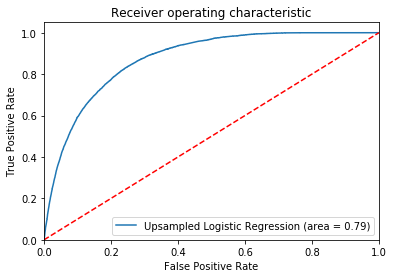

In [110]:
logit_us_roc_auc = metrics.roc_auc_score(Y_test_us, y_pred_logit_us)
fpr_logit_us, tpr_logit_us, thresholds_logit_us = metrics.roc_curve(
    Y_test_us, logit_us.predict_proba(X_test_dtm_us)[:,1])
plt.figure()
plt.plot(fpr_logit_us, tpr_logit_us, label='Upsampled Logistic Regression (area = %0.2f)' % logit_us_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Upsampled_Log_ROC')
plt.show()

### Decision Tree with Upsampled Data

In [112]:
dt_us = tree.DecisionTreeClassifier()
%time dt_us = dt_us.fit(X_train_dtm_us, Y_train_us)

Wall time: 21min 37s


In [113]:
y_pred_dt_us = dt_us.predict(X_test_dtm_us)
print('Dt Upsampled predictive accuracy: {:.2f}'.format(dt_us.score(X_test_dtm_us, Y_test_us)))

Dt Upsampled predictive accuracy: 0.97


In [114]:
# calculate precision and recall
print(classification_report(Y_test_us, y_pred_dt_us))

# calculate the confusion matrix
dt_us_conf_mat = metrics.confusion_matrix(Y_test_us, y_pred_dt_us)
print(dt_us_conf_mat)

             precision    recall  f1-score   support

          0       0.99      0.95      0.97     86439
          1       0.95      0.99      0.97     87142

avg / total       0.97      0.97      0.97    173581

[[82185  4254]
 [  941 86201]]


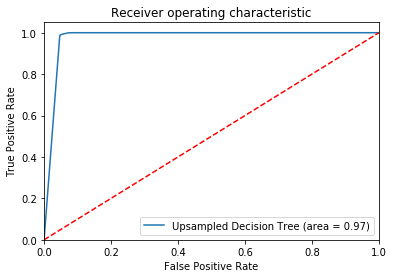

In [123]:
dt_us_roc_auc = metrics.roc_auc_score(Y_test_us, y_pred_dt_us)
fpr_dt_us, tpr_dt_us, thresholds_dt_us = metrics.roc_curve(
    Y_test_us, dt_us.predict_proba(X_test_dtm_us)[:,1])
plt.figure()
plt.plot(fpr_dt_us, tpr_dt_us, label='Upsampled Decision Tree (area = %0.2f)' % dt_us_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Upsampled_DT_ROC')
plt.show()

In [116]:
from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier(solver='lbfgs', alpha=1e-5,
                     hidden_layer_sizes=(5, 2), random_state=1)

In [117]:
%time mlp.fit(X_train_dtm_us, Y_train_us)

Wall time: 5min 26s


MLPClassifier(activation='relu', alpha=1e-05, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(5, 2), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=1, shuffle=True,
       solver='lbfgs', tol=0.0001, validation_fraction=0.1, verbose=False,
       warm_start=False)

In [119]:
y_pred_mlp_us = mlp.predict(X_test_dtm_us)
print('MLP Upsampled predictive accuracy: {:.2f}'.format(mlp.score(X_test_dtm_us, Y_test_us)))

MLP Upsampled predictive accuracy: 0.76


In [121]:
# calculate precision and recall
print(classification_report(Y_test_us, y_pred_mlp_us))

# calculate the confusion matrix
mlp_us_conf_mat = metrics.confusion_matrix(Y_test_us, y_pred_mlp_us)
print(mlp_us_conf_mat)

             precision    recall  f1-score   support

          0       0.76      0.76      0.76     86439
          1       0.76      0.76      0.76     87142

avg / total       0.76      0.76      0.76    173581

[[65779 20660]
 [21248 65894]]


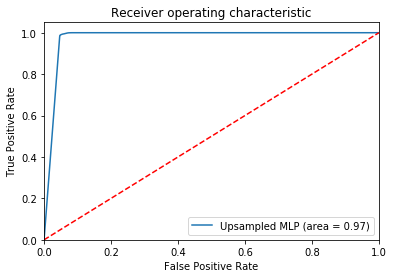

In [122]:
mlp_us_roc_auc = metrics.roc_auc_score(Y_test_us, y_pred_mlp_us)
fpr_mlp_us, tpr_mlp_us, thresholds_mlp_us = metrics.roc_curve(
    Y_test_us, dt_us.predict_proba(X_test_dtm_us)[:,1])
plt.figure()
plt.plot(fpr_dt_us, tpr_dt_us, label='Upsampled MLP (area = %0.2f)' % dt_us_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Upsampled_MLP_ROC')
plt.show()

### Grouping findings by patient

In [125]:
data = train_dta_ild[['patient_id','findings_cleaned', 'ild_status']]

In [163]:
%time all_findings_data = pd.DataFrame({'all_findings_cleaned' : data.groupby('patient_id')['findings_cleaned'].apply(lambda x: ''.join(x))}).reset_index()

Wall time: 8.49 s


In [167]:
len(all_findings_data)

82695

In [169]:
len(data['patient_id'].unique())

82695

In [170]:
all_findings_data.to_csv('all_findings_data.csv')